In [0]:
# ML_in_Finance-G-learning-wealth-management
# Author: Igor Halperin
# Version: 1.0 (12.8.2019)
# License: MIT
# Email: ighalp@gmail.com
# Notes: tested on Mac OS X with Python 3.6 and PyTorch 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., I. Halperin and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

## G-learning for wealth optimization

Using G-learning with quadratic rewards for optimization of defined contribution retirement plan

In [0]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt 
%matplotlib inline

import time

import torch

import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

In [4]:
torch.__version__

'1.4.0'

In [5]:
%env KMP_DUPLICATE_LIB_OK=TRUE

env: KMP_DUPLICATE_LIB_OK=TRUE


In [0]:
# set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
class G_learning_portfolio_opt:
    
    def __init__(self, 
                 num_steps,
                 params,
                 beta,
                 benchmark_portf,
                 gamma, 
                 num_risky_assets,
                 riskfree_rate,
                 exp_returns, # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns of risky assets
                 init_x_vals, # array of initial asset position values (num_risky_assets + 1)
                 use_for_WM = True): # use for wealth management tasks

                
        self.num_steps = num_steps
        self.num_assets = num_risky_assets + 1 # exp_returns.shape[1]
        
        self.lambd = torch.tensor(params[0], requires_grad=False, dtype=torch.float64)
        self.Omega_mat = params[1] * torch.eye(self.num_assets,dtype=torch.float64)
        #self.Omega_mat = torch.tensor(Omega_mat,requires_grad=False, dtype=torch.float64)
        self.eta = torch.tensor(params[2], requires_grad=False, dtype=torch.float64)
        self.rho = torch.tensor(params[3], requires_grad=False, dtype=torch.float64)
        self.beta = torch.tensor(beta, requires_grad=False, dtype=torch.float64)
        
        self.gamma = gamma
        self.use_for_WM = use_for_WM
        
        self.num_risky_assets = num_risky_assets
        self.r_f = riskfree_rate
        
        
        assert exp_returns.shape[0] == self.num_steps
        assert Sigma_r.shape[0] == Sigma_r.shape[1]
        assert Sigma_r.shape[0] == num_risky_assets # self.num_assets
        
        self.Sigma_r_np = Sigma_r # array of shape num_stocks x num_stocks
        
        self.reg_mat = 1e-3*torch.eye(self.num_assets, dtype=torch.float64)
        
        # arrays of returns for all assets including the risk-free asset
        # array of shape num_steps x (num_stocks + 1) 
        self.exp_returns_np = np.hstack((self.r_f * np.ones(self.num_steps).reshape((-1,1)), exp_returns))
                                      
        # make block-matrix Sigma_r_tilde with Sigma_r_tilde[0,0] = 0, and equity correlation matrix inside
        self.Sigma_r_tilde_np = np.zeros((self.num_assets, self.num_assets))
        self.Sigma_r_tilde_np[1:,1:] = self.Sigma_r_np
            
        # make Torch tensors  
        self.exp_returns = torch.tensor(self.exp_returns_np,requires_grad=False, dtype=torch.float64)
        self.Sigma_r = torch.tensor(Sigma_r,requires_grad=False, dtype=torch.float64)
        self.Sigma_r_tilde = torch.tensor(self.Sigma_r_tilde_np,requires_grad=False, dtype=torch.float64)
        
        self.benchmark_portf = torch.tensor(benchmark_portf, requires_grad=False, dtype=torch.float64)
        
        # asset holding values for all times. Initialize with initial values, 
        # values for the future times will be expected values 
        self.x_vals_np = np.zeros((self.num_steps, self.num_assets))
        self.x_vals_np[0,:] = init_x_vals 
        
        # Torch tensor
        self.x_vals = torch.tensor(self.x_vals_np)
                
        # allocate memory for coefficients of R-, F- and G-functions        
        self.F_xx = torch.zeros(self.num_steps, self.num_assets, self.num_assets, dtype=torch.float64,
                                requires_grad=True)
        self.F_x = torch.zeros(self.num_steps, self.num_assets, dtype=torch.float64,
                               requires_grad=True)
        self.F_0 = torch.zeros(self.num_steps,dtype=torch.float64,requires_grad=True)
        
        self.Q_xx = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64,
                                requires_grad=True)
        self.Q_uu = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64,
                                requires_grad=True)
        self.Q_ux = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64,
                                requires_grad=True)
        self.Q_x = torch.zeros(self.num_steps, self.num_assets,dtype=torch.float64,requires_grad=True)
        self.Q_u = torch.zeros(self.num_steps, self.num_assets,dtype=torch.float64,requires_grad=True)
        self.Q_0 = torch.zeros(self.num_steps,dtype=torch.float64,requires_grad=True)
        
        self.R_xx = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64,
                                requires_grad=True)
        self.R_uu = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64,
                                requires_grad=True)
        self.R_ux = torch.zeros(self.num_steps, self.num_assets, self.num_assets,dtype=torch.float64,
                                requires_grad=True)
        self.R_x = torch.zeros(self.num_steps, self.num_assets,dtype=torch.float64,requires_grad=True)
        self.R_u = torch.zeros(self.num_steps, self.num_assets,dtype=torch.float64,requires_grad=True)
        self.R_0 = torch.zeros(self.num_steps,dtype=torch.float64,requires_grad=True)

        
        self.reset_prior_policy()
        
        # the list of adjustable model parameters:
        self.model_params = [self.lambd, self.beta, self.Omega_mat, self.eta]  
#                              self.exp_returns, self.Sigma_r_tilde,self.Sigma_prior_inv, self.u_bar_prior]
        
        
        # expected cash installment for all steps
        self.expected_c_t = torch.zeros(self.num_steps,dtype=torch.float64)
        
        # realized values of the target portfolio
#         self.realized_target_portf = torch.zeros(self.num_steps,dtype=torch.float64)
        self.realized_target_portf = np.zeros(self.num_steps,dtype=np.float64)
        
        # expected portfolio values for all times
        self.expected_portf_val = torch.zeros(self.num_steps,dtype=torch.float64)
        
        # the first value is the sum of initial position values
        self.expected_portf_val[0] = self.x_vals[0,:].sum()

    def reset_prior_policy(self):
        # initialize time-dependent parameters of prior policy 
        self.u_bar_prior = torch.zeros(self.num_steps,self.num_assets,requires_grad=False,
                                       dtype=torch.float64)
        self.v_bar_prior =  torch.zeros(self.num_steps, self.num_assets, self.num_assets,requires_grad=False,
                                        dtype=torch.float64)
        self.Sigma_prior =  torch.zeros(self.num_steps, self.num_assets, self.num_assets,requires_grad=False,
                                        dtype=torch.float64)
        self.Sigma_prior_inv = torch.zeros(self.num_steps, self.num_assets, self.num_assets,requires_grad=False,
                                        dtype=torch.float64)
        
        # make each time elements of v_bar_prior and Sigma_prior proportional to the unit matrix
        for t in range(self.num_steps):
            self.v_bar_prior[t,:,:] = 0.1 * torch.eye(self.num_assets).clone()
            self.Sigma_prior[t,:,:] = 0.1 * torch.eye(self.num_assets).clone()
            self.Sigma_prior_inv[t,:,:] = 10.0 * torch.eye(self.num_assets).clone() # np.linalg.inv(self.Sigma_prior[t,:,:])
    
    def reward_fun(self, t, x_vals, u_vals, exp_rets, lambd, Sigma_hat):
        """
        The reward function 
        """
        x_plus = x_vals + u_vals
        
        p_hat = self.rho.clone() * self.benchmark_portf[t] + (1-self.rho.clone())*self.eta.clone()*x_vals.sum()
        
        aux_1 = - self.lambd.clone() * p_hat**2         
        aux_2 = - u_vals.sum()   
        aux_3 = 2*self.lambd.clone() * p_hat * x_plus.dot(torch.ones(num_assets) + exp_rets)
        aux_4 = - self.lambd.clone() * x_plus.mm(Sigma_hat.mv(x_plus))
        aux_5 = - u_vals.mm(self.Omega_mat.clone().mv(u_vals))
        
        return aux_1 + aux_2 + aux_3 + aux_4 + aux_5  
    
    def compute_reward_fun(self):
        """
        Compute coefficients R_xx, R_ux, etc. for all steps
        """
        for t in range(0, self.num_steps):
            
            one_plus_exp_ret = torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[t,:]
            benchmark_portf = self.benchmark_portf[t]
            Sigma_hat = self.Sigma_r_tilde + torch.ger(one_plus_exp_ret, one_plus_exp_ret)
            
            one_plus_exp_ret_by_one = torch.ger(one_plus_exp_ret,torch.ones(self.num_assets,dtype=torch.float64))
            one_plus_exp_ret_by_one_T = one_plus_exp_ret_by_one.t()     
            one_one_T_mat = torch.ones(self.num_assets,self.num_assets)
            
            self.R_xx[t,:,:] = (-self.lambd.clone()*(self.eta.clone()**2)*(self.rho.clone()**2)*one_one_T_mat
                                 + 2*self.lambd.clone()*self.eta.clone()*self.rho.clone()*one_plus_exp_ret_by_one
                                 - self.lambd.clone()*Sigma_hat)
            
            self.R_ux[t,:,:] = (2*self.lambd.clone()*self.eta.clone()*self.rho.clone()*one_plus_exp_ret_by_one
                                 - 2*self.lambd.clone()*Sigma_hat)
            
            self.R_uu[t,:,:] = - self.lambd.clone() * Sigma_hat - self.Omega_mat.clone()
            
            self.R_x[t,:] =  (-2*self.lambd.clone()*self.eta.clone()*self.rho.clone()*(1-self.rho.clone())*benchmark_portf *
                                 torch.ones(self.num_assets,dtype=torch.float64)
                                 + 2*self.lambd.clone()*(1-self.rho.clone())*benchmark_portf * one_plus_exp_ret)
            
            self.R_u[t,:] = (2*self.lambd.clone()*(1-self.rho.clone())*benchmark_portf * one_plus_exp_ret
                             - torch.ones(self.num_assets,dtype=torch.float64))
            
            self.R_0[t] = - self.lambd.clone()*((1-self.rho.clone())**2) * (benchmark_portf**2)
                
         
    def project_cash_injections(self):
        """
        Compute the expected values of future asset positions, and the expected cash injection for future steps,
        as well as realized values of the target portfolio
        """
           
        # this assumes that the policy is trained
        for t in range(1, self.num_steps):  # the initial value is fixed 
            
            # increment the previous x_t
            
            delta_x_t = self.u_bar_prior[t,:] + self.v_bar_prior[t,:,:].mv(self.x_vals[t-1,:])
            self.x_vals[t,:] = self.x_vals[t-1,:] + delta_x_t
            
            # grow using the expected return
            self.x_vals[t,:] = (torch.ones(self.num_assets)+ self.exp_returns[t,:])*self.x_vals[t,:]
            
            # compute c_t
            self.expected_c_t[t] = delta_x_t.sum().data # detach().numpy()
            
            # expected portfolio value for this step
            self.expected_portf_val[t] = self.x_vals[t,:].sum().data # .detach().numpy()
    
#             self.realized_target_portf[t] = (self.x_vals[t,:].sum().data) * (self.eta.detach().numpy())[0]
            
                                                                                      
    def set_terminal_conditions(self):
        """
        set the terminal condition for the F-function
        """
        
        # the auxiliary quantity to perform matrix calculations
        one_plus_exp_ret = torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[-1,:]
        
        
        # compute the reward function for all steps (only the last step is needed for this functions, while 
        # values for other time steps will be used in other functions)
        self.compute_reward_fun()
        
        if self.use_for_WM:

            # Note: Pinv in PyTorch may be inaccurate, 
            # see https://discuss.pytorch.org/t/torch-pinverse-seems-to-be-inaccurate/33616
            Sigma_hat = self.Sigma_r_tilde + torch.ger(one_plus_exp_ret, one_plus_exp_ret)
            #Sigma_hat_inv = torch.pinverse(Sigma_hat)
            Sigma_hat_inv = torch.inverse(Sigma_hat + self.reg_mat)
            
            Sigma_tilde = Sigma_hat + (1/self.lambd)*self.Omega_mat.clone()
            #Sigma_tilde_inv = torch.pinverse(Sigma_tilde)
            Sigma_tilde_inv = torch.inverse(Sigma_tilde + self.reg_mat)
            
            Sigma_hat_sigma_tilde = Sigma_hat.mm(Sigma_tilde)
            Sigma_tilde_inv_sig_hat = Sigma_tilde_inv.mm(Sigma_hat)
            Sigma_tilde_sigma_hat = Sigma_tilde.mm(Sigma_hat)
            
            Sigma_hat_Sigma_tilde_inv = Sigma_hat.mm(Sigma_tilde_inv)
            Sigma_3_plus_omega = self.lambd*Sigma_tilde_inv.mm(Sigma_hat_Sigma_tilde_inv) + self.Omega_mat.clone()    
                 
            # matrix Phi
#             Phi_m = (self.eta*torch.ger(one_plus_exp_ret,torch.ones(self.num_assets,dtype=torch.float64)) 
#                      - Sigma_tilde_inv)
            
            one_plus_exp_ret_by_one = torch.ger(one_plus_exp_ret,torch.ones(self.num_assets,dtype=torch.float64))
            one_plus_exp_ret_by_one_T = one_plus_exp_ret_by_one.t()     
            one_one_T_mat = torch.ones(self.num_assets,self.num_assets)
            
            Sigma_tilde_inv_t_R_ux = Sigma_tilde_inv.t().mm(self.R_ux[-1,:,:].clone())
            Sigma_tilde_inv_t_R_uu = Sigma_tilde_inv.t().mm(self.R_uu[-1,:,:].clone())
            Sigma_tilde_inv_t_R_u = Sigma_tilde_inv.t().mv(self.R_u[-1,:].clone())
            
            Sigma_tilde_inv_R_u = Sigma_tilde_inv.mv(self.R_u[-1,:].clone())
            Sigma_tilde_inv_R_ux = Sigma_tilde_inv.mm(self.R_ux[-1,:,:].clone())
            Sigma_tilde_inv_t_R_uu = Sigma_tilde_inv.mm(self.R_uu[-1,:,:].clone())
            
            # though the action at the last step is deterministic, we can feed 
            # parameters of the prior with these values                     
              
            self.u_bar_prior[-1,:]   = (1/(2 * self.lambd.clone()))* Sigma_tilde_inv.clone().mv(self.R_u[-1,:].clone())
            self.v_bar_prior[-1,:,:] = (1/(2 * self.lambd.clone()))* Sigma_tilde_inv.clone().mm(self.R_ux[-1,:,:].clone())    
                
            # First compute the coefficients of the reward function at the last step

            
            # the coefficients of F-function for the last step
            
            # F_xx                 
            self.F_xx[-1,:,:] = (self.R_xx[-1,:,:].clone()
                                 + (1/(2*self.lambd.clone()))* self.R_ux[-1,:,:].clone().t().mm(Sigma_tilde_inv_t_R_ux)
                                 + (1/(4*self.lambd.clone()**2))* self.R_ux[-1,:,:].clone().t().mm(
                                      Sigma_tilde_inv_t_R_uu.clone().mm(Sigma_tilde_inv.clone().mm(self.R_ux[-1,:,:].clone())))
                                )
            
            # F_x                    
            self.F_x[-1,:] = (self.R_x[-1,:].clone()
                                 + (1/(self.lambd.clone()))* self.R_ux[-1,:,:].clone().t().mv(Sigma_tilde_inv_t_R_u.clone())
                                 + (1/(2*self.lambd.clone()**2))* self.R_ux[-1,:,:].clone().t().mv(
                                      Sigma_tilde_inv_t_R_uu.clone().mv(Sigma_tilde_inv_R_u.clone()))
                            )
            
            
        
            # F_0   
            self.F_0[-1] = (self.R_0[-1].clone() 
                            +  (1/(2*self.lambd.clone()))* self.R_u[-1,:].clone().dot(Sigma_tilde_inv_R_u.clone())
                            + (1/(4*self.lambd.clone()**2))* self.R_u[-1,:].clone().dot(
                                Sigma_tilde_inv_t_R_uu.clone().mv(Sigma_tilde_inv_R_u.clone()))
                           )
            
            # for the Q-function at the last step:
            self.Q_xx[-1,:,:] = self.R_xx[-1,:,:].clone()
            self.Q_ux[-1,:,:] = self.R_ux[-1,:,:].clone()
            self.Q_uu[-1,:,:] = self.R_uu[-1,:,:].clone()
            self.Q_u[-1,:] = self.R_u[-1,:].clone()
            self.Q_x[-1,:] = self.R_x[-1,:].clone()
            self.Q_0[-1] = self.R_0[-1].clone()
            
            
            
            
                
    def G_learning(self, err_tol, max_iter):
        """
        find the optimal policy for the time dependent policy
        
        """
        
        print('Doing G-learning, it may take a few seconds...')
        
        # set terminal conditions
        self.set_terminal_conditions()
        
        # allocate iteration numbers for all steps
        self.iter_counts = np.zeros(self.num_steps)
        
        # iterate over time steps backward
        for t in range(self.num_steps-2,-1,-1):
            self.step_G_learning(t, err_tol, max_iter)
            
    def step_G_learning(self, t, err_tol, max_iter):
        """
        Perform one step of backward iteration for G-learning self-consistent equations
        This should start from step t = num_steps - 2 (i.e. from a step that is before the last one)
        """
            
        # local variables
        #F_xx_tp1 = self.F_xx[t+1,:,:]
        #F_x_tp1 = self.F_x[t+1,:]
        #F_0_tp1 = self.F_0[t+1]
            
        # make matrix Sigma_hat_t        
        one_plus_exp_ret = torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[t,:]
        Sigma_hat_t = self.Sigma_r_tilde + torch.ger(one_plus_exp_ret, one_plus_exp_ret)
        
        # matrix A_t = diag(1 + r_bar_t)
        A_t = torch.diag(torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[t,:])
                    
        # update parameters of Q_function using next-step F-function values
        self.update_Q_params(t, A_t,Sigma_hat_t)
             
        # iterate between policy evaluation and policy improvement  
        while self.iter_counts[t] < max_iter:
                
            curr_u_bar_prior = self.u_bar_prior[t,:].clone()  
            curr_v_bar_prior = self.v_bar_prior[t,:,:].clone()     
                
            # compute parameters of F-function for this step from parameters of Q-function
            self.update_F_params(t) 
              
            # Policy iteration step: update parameters of the prior policy distribution
            # with given Q- and F-function parameters
            self.update_policy_params(t)    
            
            # difference between the current value of u_bar_prior and the previous one
            err_u_bar = torch.sum((curr_u_bar_prior - self.u_bar_prior[t,:])**2)
            
            # divide by num_assets in err_v_bar to get both errors on a comparable scale
            err_v_bar = (1/self.num_assets)*torch.sum((curr_v_bar_prior - self.v_bar_prior[t,:,:])**2)
            
            # choose the difference from the previous iteration as the maximum of the two errors
            tol = torch.max(err_u_bar, err_v_bar)  # tol = 0.5*(err_u_bar + err_v_bar)

#             print('err_u_bar, err_v_bar, tol', err_u_bar, err_v_bar, tol)
            
            self.iter_counts[t] += 1
            # Repeat the calculation of Q- and F-values
            if tol <= err_tol:
                break
                
            
    def update_Q_params(self,t, A_t,Sigma_hat_t):
        """
        update the current (time-t) parameters of Q-function from (t+1)-parameters of F-function
        """ 
                
        ones = torch.ones(self.num_assets,dtype=torch.float64)    
        one_plus_exp_ret = torch.ones(self.num_assets,dtype=torch.float64) + self.exp_returns[t,:]
#         one_plus_exp_ret_1T = torch.ger(one_plus_exp_ret, ones)
    
        self.Q_xx[t,:,:] = (self.R_xx[t,:,:].clone() 
                            + self.gamma *( (A_t.clone().mm(self.F_xx[t+1,:,:].clone())).mm(A_t.clone())  
                                           + self.Sigma_r_tilde.clone() * self.F_xx[t+1,:,:].clone() ) )


        self.Q_ux[t,:,:] = (self.R_ux[t,:,:].clone() 
                            + 2 * self.gamma *( (A_t.clone().mm(self.F_xx[t+1,:,:].clone())).mm(A_t.clone())  
                                           + self.Sigma_r_tilde.clone() * self.F_xx[t+1,:,:].clone() ) 
                           )
    
        self.Q_uu[t,:,:] = (self.R_uu[t,:,:].clone()  
                            + self.gamma *( (A_t.clone().mm(self.F_xx[t+1,:,:].clone())).mm(A_t.clone())  
                                           + self.Sigma_r_tilde.clone() * self.F_xx[t+1,:,:].clone() )
                            - self.Omega_mat.clone()
                           )


        self.Q_x[t,:] = self.R_x[t,:].clone() + self.gamma * A_t.clone().mv(self.F_x[t+1,:].clone()) 
        self.Q_u[t,:] = self.R_u[t,:].clone() + self.gamma * A_t.clone().mv(self.F_x[t+1,:].clone())
        self.Q_0[t]   = self.R_0[t].clone() + self.gamma * self.F_0[t+1].clone()


        
    def update_F_params(self,t):
        """
        update the current (time-t) parameters of F-function from t-parameters of G-function
        This is a policy evaluation step: it uses the current estimations of the mean parameters of the policy
        
        """
        
        # produce auxiliary parameters U_t, W_t, Sigma_tilde_t
        U_t = (self.beta.clone() * self.Q_ux[t,:,:].clone() 
               + self.Sigma_prior_inv[t,:,:].clone().mm(self.v_bar_prior[t,:,:].clone()))
        W_t = (self.beta.clone() * self.Q_u[t,:].clone() 
               +  self.Sigma_prior_inv[t,:,:].clone().mv(self.u_bar_prior[t,:]).clone())
        Sigma_p_bar =  self.Sigma_prior_inv[t,:,:].clone() - 2 * self.beta.clone() * self.Q_uu[t,:,:].clone()
        #Sigma_p_bar_inv = torch.pinverse(Sigma_p_bar)
        Sigma_p_bar_inv = torch.inverse(Sigma_p_bar + self.reg_mat)
        
#         reg_mat = 1e-2*torch.eye(self.num_assets)
        
        # update parameters of F-function
        self.F_xx[t,:,:] = self.Q_xx[t,:,:].clone() + (1/(2*self.beta.clone()))*(U_t.t().mm(Sigma_p_bar_inv.clone().mm(U_t))
                                    - self.v_bar_prior[t,:,:].clone().t().mm(
                                        self.Sigma_prior_inv[t,:,:].clone().mm(self.v_bar_prior[t,:,:].clone())))
        
        
        self.F_x[t,:] = self.Q_x[t,:].clone() + (1/self.beta.clone())*(U_t.mv(Sigma_p_bar_inv.clone().mv(W_t))
                                    - self.v_bar_prior[t,:,:].clone().mv(
                                        self.Sigma_prior_inv[t,:,:].clone().mv(self.u_bar_prior[t,:].clone())))
        
        
#         self.F_0[t] = self.Q_0[t] + ( (1/(2*self.beta))*(W_t.dot(Sigma_p_bar_inv.mv(W_t))
#                                     - self.u_bar_prior[t,:].dot(
#                                         self.Sigma_prior_inv[t,:,:].mv(self.u_bar_prior[t,:])))
#                                     - (1/(2*self.beta)) * (torch.log(torch.det(self.Sigma_prior[t,:,:]))
#                                                        + torch.log(torch.det(Sigma_p_bar))) )
        
        # replace with a 'regularized' version
        self.F_0[t] = self.Q_0[t].clone() + ( (1/(2*self.beta.clone()))*(W_t.dot(Sigma_p_bar_inv.clone().mv(W_t))
                                    - self.u_bar_prior[t,:].clone().dot(
                                        self.Sigma_prior_inv[t,:,:].clone().mv(self.u_bar_prior[t,:].clone())))
                                    - (1/(2*self.beta.clone())) * (torch.log(torch.det(self.Sigma_prior[t,:,:].clone()+
                                                                              self.reg_mat))
                                                       - torch.log(torch.det(Sigma_p_bar_inv.clone() + self.reg_mat))) )
        
        
        
    def update_policy_params(self,t):
        """
        update parameters of the Gaussian policy using current coefficients of the F- and G-functions
        """
        
        new_Sigma_prior_inv = self.Sigma_prior_inv[t,:,:].clone() - 2 * self.beta.clone() * self.Q_uu[t,:,:].clone()
        #Sigma_prior_new = torch.pinverse(new_Sigma_prior_inv)
        Sigma_prior_new = torch.inverse(new_Sigma_prior_inv + self.reg_mat)
        
        # update parameters using the previous value of Sigma_prior_inv
        self.u_bar_prior[t,:] = Sigma_prior_new.mv(self.Sigma_prior_inv[t,:,:].clone().mv(self.u_bar_prior[t,:].clone())
                                              + self.beta.clone() * self.Q_u[t,:].clone())
        
        
        self.v_bar_prior[t,:,:] = Sigma_prior_new.clone().mm(self.Sigma_prior_inv[t,:,:].clone().mm(self.v_bar_prior[t,:,:].clone())
                                              + self.beta.clone() * self.Q_ux[t,:,:].clone())
        
        # and then assign the new inverse covariance for the prior for the next iteration
        self.Sigma_prior[t,:,:] = Sigma_prior_new.clone()
        self.Sigma_prior_inv[t,:,:] = new_Sigma_prior_inv.clone()
        
        # also assign the same values for the previous time step
        if t > 0:
            self.Sigma_prior[t-1,:,:] = self.Sigma_prior[t,:,:].clone()
            self.u_bar_prior[t-1,:] = self.u_bar_prior[t,:].clone()
            self.v_bar_prior[t-1,:,:] = self.v_bar_prior[t,:,:].clone()
            
    def trajs_to_torch_tensors(self,trajs):
        """
        Convert data from a list of lists into Torch tensors
        """
        num_trajs = len(trajs)
        
        self.data_xvals = torch.zeros(num_trajs,self.num_steps,self.num_assets,dtype=torch.float64)
        self.data_uvals = torch.zeros(num_trajs,self.num_steps,self.num_assets,dtype=torch.float64)
            
        for n in range(num_trajs):
            for t in range(self.num_steps):
                self.data_xvals[n,t,:] = torch.tensor(trajs[n][t][0],dtype=torch.float64).clone()
                self.data_uvals[n,t,:] = torch.tensor(trajs[n][t][1],dtype=torch.float64).clone()
                
    def compute_reward_on_traj(self,
                              t,
                              x_t, u_t):
        """
        Given time t and corresponding values of vectors x_t, u_t, compute the total reward for this step
        """
        
        aux_xx = x_t.dot(self.R_xx[t,:,:].clone().mv(x_t))
        aux_ux = u_t.dot(self.R_ux[t,:,:].clone().mv(x_t))
        aux_uu = u_t.dot(self.R_uu[t,:,:].clone().mv(u_t))
        aux_x = x_t.dot(self.R_x[t,:].clone())
        aux_u = u_t.dot(self.R_u[t,:].clone())
        aux_0 = self.R_0[t].clone()
        
        return aux_xx + aux_ux + aux_uu + aux_x + aux_u + aux_0
    
    def compute_G_fun_on_traj(self,
                              t,
                              x_t, u_t):
        """
        Given time t and corresponding values of vectors x_t, u_t, compute the total reward for this step
        """
        
        aux_xx = x_t.dot(self.Q_xx[t,:,:].clone().mv(x_t))
        aux_ux = u_t.dot(self.Q_ux[t,:,:].clone().mv(x_t))
        aux_uu = u_t.dot(self.Q_uu[t,:,:].clone().mv(u_t))
        aux_x = x_t.dot(self.Q_x[t,:].clone())
        aux_u = u_t.dot(self.Q_u[t,:].clone())
        aux_0 = self.Q_0[t].clone()
        
        return aux_xx + aux_ux + aux_uu + aux_x + aux_u + aux_0
    
    def compute_F_fun_on_traj(self,
                              t,
                              x_t):
        """
        Given time t and corresponding values of vectors x_t, u_t, compute the total reward for this step
        """
        
        aux_xx = x_t.dot(self.F_xx[t,:,:].clone().mv(x_t))
        aux_x = x_t.dot(self.F_x[t,:].clone())
        aux_0 = self.F_0[t].clone()
        
        return aux_xx + aux_x + aux_0

                 
    def MaxEntIRL(self,
                  trajs,
                  learning_rate,
                  err_tol, max_iter):
        
        """
        Estimate parameters of the reward function using MaxEnt IRL.
        Inputs:
        
        trajs - a list of trajectories. Each trajectory is a list of state-action pairs, stored as a tuple.
                We assume each trajectory has the same length
        """
        
        # omega is a tunable parameter that determines the cost matrix self.Omega_mat
        omega_init = 15.0
        self.omega = torch.tensor(omega_init, requires_grad=True, dtype=torch.float64)
        
        # also set beta to be small 
        beta_init = 50 # 1.0
        self.beta = torch.tensor(beta_init, requires_grad=True, dtype=torch.float64)
        
        reward_params =  [self.lambd, self.eta, self.rho, self.omega, self.beta]
        
        print("Omega mat...")
        self.Omega_mat = self.omega * torch.eye(self.num_assets,dtype=torch.float64)
        print("g learning...")
        self.reset_prior_policy()
        self.G_learning(err_tol, max_iter)
        print("intialize optimizer...")
        optimizer = optim.Adam(reward_params, lr=learning_rate)
        print("zero grad...")
        optimizer.zero_grad()
        
        num_trajs = len(trajs)
        print("trajs_to_torch_tensors...")
        # fill in Torch tensors for the trajectory data
        self.trajs_to_torch_tensors(trajs)
        print("constructing zero tensors...")   
        self.realized_rewards = torch.zeros(num_trajs,self.num_steps,dtype=torch.float64,requires_grad=True)
        self.realized_cum_rewards = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=True)
        print("constructing zero tensors...")  
        self.realized_G_fun = torch.zeros(num_trajs,self.num_steps,dtype=torch.float64, requires_grad=True)
        self.realized_F_fun = torch.zeros(num_trajs,self.num_steps,dtype=torch.float64, requires_grad=True)
        print("constructing zero tensors...")  
        self.realized_G_fun_cum = torch.zeros(num_trajs,dtype=torch.float64, requires_grad=True)
        self.realized_F_fun_cum = torch.zeros(num_trajs,dtype=torch.float64, requires_grad=True)
        print("done...")  
        
        num_iter_IRL = 3
        
        for i in range(num_iter_IRL):
            
            print('GIRL iteration = ', i)
       
            self.Omega_mat = self.omega * torch.eye(self.num_assets,dtype=torch.float64)
    
#             for n in range(num_trajs):
            for n in range(101):
                if n%100==0:
                    print(n)
                for t in range(self.num_steps):
                    
                    
                    # compute rewards obtained at each step for each trajectory
                    # given the model paramaters
        
                    self.realized_rewards[n,t] = self.compute_reward_on_traj(t,
                                                                self.data_xvals[n,t,:],
                                                                self.data_uvals[n,t,:])
                                                                
            
                    # compute the log-likelihood by looping over trajectories
                    self.realized_G_fun[n,t] = self.compute_G_fun_on_traj(t,
                                                                self.data_xvals[n,t,:],
                                                                self.data_uvals[n,t,:])
                
                
                    self.realized_F_fun[n,t] = self.compute_F_fun_on_traj(t,
                                                                self.data_xvals[n,t,:])
                

                self.realized_cum_rewards[n] = self.realized_rewards[n,:].sum().clone()
                self.realized_G_fun_cum[n] = self.realized_G_fun[n,:].sum().clone()
                self.realized_F_fun_cum[n] = self.realized_F_fun[n,:].sum().clone()
            
            # the negative log-likelihood will not include terms ~ Sigma_p as we do not optimize over its value
            loss = - self.beta.clone()*(self.realized_G_fun_cum.sum().clone() - self.realized_F_fun_cum.sum().clone())
        
            optimizer.zero_grad()
        
            loss.backward() 
        
            optimizer.step()
        
            print('Iteration = ', i)
            print('Loss = ', loss.detach().numpy())
        
           
        print('Done optimizing reward parameters')
            

## Simulate portfolio data

### Simulate the market factor as a lognormal with a fixed drift and vol

In [0]:
mu_market = 0.05
vol_market = 0.25
init_market_val = 100.0

r_rf = 0.02  # risk-free rate - the first asset will be cash

num_steps = 30
dt = 0.25 # quarterly time steps

num_risky_assets = 99 # 100

returns_market = np.zeros(num_steps)
market_vals = np.zeros(num_steps)
market_vals[0] = 100.0  # initial value


        
for t in range(1,num_steps):

        rand_norm = np.random.randn()
        
        # use log-returns of market as 'returns_market'
        returns_market[t] = mu_market * dt + vol_market * np.sqrt(dt) * rand_norm
        
        market_vals[t] = market_vals[t-1] * np.exp((mu_market - 0.5*vol_market**2)*dt + 
                                                         vol_market*np.sqrt(dt)*rand_norm)
        

In [0]:
#plt.plot(market_vals)

### Simulate market betas and idiosyncratic alphas within pre-defined ranges

In [5]:
beta_min = 0.05
beta_max = 0.85
beta_vals = np.random.uniform(low=beta_min, high=beta_max, size=num_risky_assets)

alpha_min = - 0.05
alpha_max = 0.15
alpha_vals = np.random.uniform(low=alpha_min, high=alpha_max, size=num_risky_assets)

print(beta_vals[0:10])
print(alpha_vals[0:10])

[0.64545898 0.84427527 0.19006579 0.38414414 0.36938121 0.55065814
 0.84733618 0.26378198 0.14365236 0.59750728]
[-0.02323255  0.08195309  0.10922259  0.05964297  0.11034211  0.00641097
 -0.04676893  0.14620699  0.13589093 -0.03478873]


### Simulate time-dependent expected returns

In [0]:
# time-independent expected returns would be equal to alpha + beta * expected_market_return 
# make them time-dependent (and correlated with actual returns) as alpha + beta * oracle_market_returns
# oracle expected returns pick into the future! 

oracle_coeff = 0.2
mu_vec = mu_market * np.ones(num_steps)
oracle_market_returns = mu_vec * dt + oracle_coeff*(returns_market - mu_vec) ## missing dt --> mu_vec*dt?

expected_risky_returns = np.zeros((num_steps, num_risky_assets))

for t in range(num_steps):
    expected_risky_returns[t,:] = alpha_vals * dt + beta_vals * oracle_market_returns[t]

### Initial values of all assets 

In [0]:
val_min = 20.0
val_max = 120.0

init_risky_asset_vals = np.random.uniform(low=val_min, high=val_max, size=num_risky_assets)

### Simulate realized returns and asset prices

In [0]:
# make realized returns and realized asset values by simulating from a one-factor model 
# with time-dependent expected returns

risky_asset_returns = np.zeros((num_steps, num_risky_assets))
risky_asset_vals = np.zeros((num_steps, num_risky_assets))

idiosync_vol =  0.05 # vol_market #  

for t in range(num_steps):
    
    rand_norm = np.random.randn(num_risky_assets)
        
    # asset returns are simulated from a one-factor model
    risky_asset_returns[t,:] = (expected_risky_returns[t,:] + beta_vals * (returns_market[t] - mu_market * dt) 
                         + idiosync_vol * np.sqrt(1 - beta_vals**2) * np.sqrt(dt) * rand_norm)
        
    # asset values
    if t == 0:
        risky_asset_vals[t,:] = init_risky_asset_vals
    else:
        risky_asset_vals[t] = risky_asset_vals[t-1] * (1 + risky_asset_returns[t,:])
   

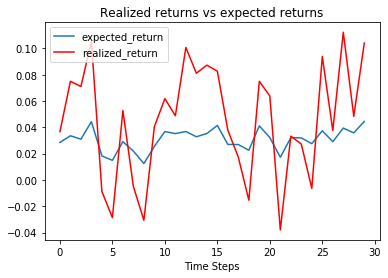

In [11]:
# compare the realized and expected returns
# Note that they appear correlated - this is because we constructed them so!

# pick a random asset to show
asset_idx =  4 # 8 # 6 # 5

plt.plot(expected_risky_returns[:,asset_idx],label='expected_return')
plt.plot(risky_asset_returns[:,asset_idx],label='realized_return',color='r')
plt.legend()
plt.xlabel('Time Steps')
plt.title('Realized returns vs expected returns')
plt.show()


### Compute the empirical correlation matrix using realized returns

In [12]:
cov_mat_r = np.cov(risky_asset_returns.T) 

print(cov_mat_r.shape)

D,v = np.linalg.eigh(cov_mat_r)

eigenvals = D[::-1]  # put them in a descended order

(99, 99)


In [12]:
# eigenvalues: the largest eigenvalue is the market factor 
eigenvals[0:10]

array([0.66923388, 0.00401052, 0.00345997, 0.00333454, 0.00320023,
       0.00273543, 0.00268514, 0.00254346, 0.00235859, 0.00212307])

In [13]:
cov_mat_torch = torch.tensor(cov_mat_r)

torch.pinverse(cov_mat_torch)

tensor([[248.0082, -14.0834,  -6.2964,  ...,  27.4848,  13.9297,  14.4174],
        [-14.0834, 174.4414,  38.8211,  ...,  23.9781,   5.3589,  25.1636],
        [ -6.2964,  38.8211, 345.7294,  ..., -20.5320,  24.9343,   4.8420],
        ...,
        [ 27.4848,  23.9781, -20.5320,  ..., 107.2068,  33.3806,  -0.4019],
        [ 13.9297,   5.3589,  24.9343,  ...,  33.3806, 263.8205, -21.5906],
        [ 14.4174,  25.1636,   4.8420,  ...,  -0.4019, -21.5906, 149.1360]],
       dtype=torch.float64)

### Add a riskless bond as one more asset

In [0]:
num_assets = num_risky_assets + 1

bond_val = 100.0

# add the bond to initial assets
init_asset_vals = np.hstack((np.array([bond_val]),
                            init_risky_asset_vals))

### Make the initial portfolio 

In [0]:
# consider here two choices: equal or equally-weighted 

init_port_choice =  'equal' # 'equally_weighted'  #

init_cash = 1000.0
init_total_asset = np.sum(init_asset_vals)

x_vals_init = np.zeros(num_assets)

if init_port_choice == 'equal': 
    # hold equal amounts of cash in each asset
    amount_per_asset = init_cash/num_assets
    x_vals_init = amount_per_asset * np.ones(num_assets)

elif init_port_choice == 'equally_weighted':
    amount_per_asset = init_cash/init_total_asset
    x_vals_init = amount_per_asset * init_asset_vals
    


### Make the target portfolio

In [16]:
# make a target portfolio term structure by defining it as the initial portfolio growing at some fixed and high rate

target_portfolio = [init_cash]

target_return = 0.15 # 0.20
coeff_target = 1.1 # 1.2 # 1.0

for i in range(1,num_steps):
    target_portfolio.append(target_portfolio[i-1]*np.exp(dt * target_return) )
    
target_portfolio = coeff_target*np.array(target_portfolio)    
print(target_portfolio[0], target_portfolio[-1])

1100.0 3263.532441672218


### Define model parameters

In [17]:
riskfree_rate = 0.02
fee_bond = 0.05 # 0.01 # 
fee_stock = 0.05 # 0.05 # 20.0 # 0.1 # 1.0 # 100 # 1.0 # 0.5 

all_fees = np.zeros(num_risky_assets + 1)
all_fees[0] = fee_bond
all_fees[1:] = fee_stock
Omega_mat = np.diag(all_fees)


# model parameters

lambd = 0.001 #  0.00065 # 0.0006 # 0.001 # 1.0 # 5.0 # 3.0 # 5.0 # 0.1 # 0.12 # 0.08 # 0.05 # 0.0005
Omega_mat = 15.5 * np.diag(all_fees) # 16.5 * # 100.0 * np.diag(all_fees)
# Omega_mat = 120.0 * np.diag(all_fees)
eta = 1.5 # 1.3 # 1.5 # 1.2

beta = 100.0
gamma = 0.95 

exp_returns = expected_risky_returns

Sigma_r = cov_mat_r

# make the benchmark target portfolio by growing the initial portfolio value at rate eta
# benchmark_portf = [init_cash]

target_return =  0.5 # 0.4 # 0.25 # 0.15 #
# coeff_target = 1.1 # 1.2 # 1.0
benchmark_portf = [ init_cash   * np.exp(dt * target_return)]

rho = 0.4 # 0.4 # 0.2 # 0.2 # 0.5

for i in range(1,num_steps):
    benchmark_portf.append(benchmark_portf[i-1]*np.exp(dt * target_return) )
    
# target_portfolio = coeff_target*np.array(target_portfolio)    
print(benchmark_portf[0], benchmark_portf[-1])

1133.1484530668263 42521.08200006277


### Simulate portfolio data

Produce a list of trajectories, where each trajectory is a list made of state-action pairs

In [0]:
# DGP
lambd = 0.001 # 0.001
omega = 10*fee_stock 
beta = 1000
eta = 1.01 # 1.0#  1.3 # 1.5 # 1.2
rho = 0.4


In [0]:
reward_params=[lambd, omega, eta, rho]

In [0]:
# create a G-learner
G_learner = G_learning_portfolio_opt(num_steps,
                 reward_params,  
                 beta,                
                 benchmark_portf,
                 gamma, 
                 num_risky_assets,
                 riskfree_rate,
                 expected_risky_returns, # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns of risky matrix                    
                 x_vals_init, # array of initial values of len (num_stocks+1)
                 use_for_WM = True) # use for wealth management tasks

In [32]:
G_learner.reset_prior_policy()
error_tol=1.e-8 # 5.0e-5 
max_iter_RL = 200
G_learner.G_learning(error_tol, max_iter_RL)


Doing G-learning, it may take a few seconds...


In [22]:
num_sim = 1000
trajs = []
np.random.seed(0)
torch.manual_seed(0)
t_0 = time.time()


x_vals = [x_vals_init]
returns_all = []
for n in range(num_sim):
    this_traj = []
    x_t = x_vals_init[:]
    returns_array = []
    for t in range(0,num_steps):
        
        #exp_returns = np.hstack([riskfree_rate,expected_risky_returns[t,:]])
        
        #Sigma_r_np = Sigma_r # array of shape num_stocks x num_stocks
                                              
        # make block-matrix Sigma_r_tilde with Sigma_r_tilde[0,0] = 0, and equity correlation matrix inside
        #Sigma_r_tilde = np.zeros((num_assets, num_assets))
        #Sigma_r_tilde[1:,1:] = Sigma_r
        
        #one_plus_exp_ret = np.ones(num_assets) + exp_returns
        
        #Sigma_hat_t = Sigma_r_tilde + np.outer(one_plus_exp_ret, one_plus_exp_ret)
        #Sigma_tilde = Sigma_hat_t + (1/lambd)*Omega_mat
        #Sigma_tilde_inv = np.linalg.pinv(Sigma_tilde)
        
        # compute u_t
        
        # first compute R_u, R_ux
        #R_u = (- np.ones(num_assets) + 2*lambd*(1-rho)*benchmark_portf[t]*(np.ones(num_assets)+
         #                                                                exp_returns))
        
        #R_ux = (2*lambd*eta*rho*np.outer(np.ones(num_assets)+exp_returns,
         #                              np.ones(num_assets)) - 2*lambd*Sigma_hat_t)
        
        
        #u_t = (1/(2*lambd))* Sigma_tilde_inv.dot(R_u + R_ux.dot(x_t))
        
        # randomize the action
        #sigma_p = 0.2
        #rand_norm_p = np.random.randn(num_assets)
        #u_t = u_t *(np.ones(num_assets) + sigma_p*rand_norm_p)

        # sample from optimal policy \pi(u_t | x_t)
        #G_learner.update_policy_params(t)
       
        mu_t = G_learner.u_bar_prior[t,:] + G_learner.v_bar_prior[t,:].mv(torch.tensor(x_t))
        u_t = np.random.multivariate_normal(mu_t.detach().numpy(), G_learner.Sigma_prior[t,:].detach().numpy())
        # compute new values of x_t

        x_next = x_t +u_t
        # grow this with random return
        
        idiosync_vol =  0.05 # vol_market #      
        rand_norm = np.random.randn(num_risky_assets)
        
        # asset returns are simulated from a one-factor model
        risky_asset_returns = (expected_risky_returns[t,:] + beta_vals * (returns_market[t] - mu_market * dt) 
                         + idiosync_vol * np.sqrt(1 - beta_vals**2) * np.sqrt(dt) * rand_norm)
        
        returns = np.hstack((riskfree_rate*dt, risky_asset_returns))
        
        x_next = (1+returns)*x_next
        port_returns=(x_next.sum() -x_t.sum() -np.sum(u_t) - 0.015*np.abs(u_t).sum())/x_t.sum()
        #port_returns=(x_next.sum() -x_t.sum())/x_t.sum()
        
        this_traj.append((x_t, u_t))
        
        # rename
        x_t = x_next
        returns_array.append(port_returns) 
    # end the loop over time steps
    trajs.append(this_traj)
    returns_all.append(returns_array)

print('Done simulating trajectories in %f sec'% (time.time() - t_0))        

Done simulating trajectories in 173.793027 sec


### Calculate performance of G-learner (Diagnostics only)

In [0]:
returns_all_G=returns_all

In [27]:
SR_G=0
for i in range(num_sim):
  SR_G+=(np.mean(returns_all_G[i])-riskfree_rate*dt)/np.std(returns_all_G[i])

SR_G/=num_sim
print(SR_G)

0.3090938390736271


In [57]:
SR_ew=0
for i in range(num_sim):
  SR_ew+=(np.mean(returns_all_ew[i])-riskfree_rate*dt)/np.std(returns_all_ew[i])

SR_ew/=num_sim
print(SR_ew)

0.20842306660453755


In [56]:
SR_GIRL=0
for i in range(num_sim):
  SR_GIRL+=(np.mean(returns_all_GIRL[i])-riskfree_rate*dt)/np.std(returns_all_GIRL[i])

SR_GIRL/=num_sim
print(SR_GIRL)

0.410565799128623


In [0]:
r_G=np.array([0]*num_steps, dtype='float64')
for n in range(num_steps):
  for i in range(num_sim):
    r_G[n]+=returns_all_G[i][n]
  r_G[n]/=num_sim


In [0]:
r_girl=np.array([0]*num_steps, dtype='float64')
for n in range(num_steps):
  for i in range(num_sim):
    r_girl[n]+=returns_all_GIRL[i][n]
  r_girl[n]/=num_sim

In [0]:
r_ew=np.array([0]*num_steps, dtype='float64')
for n in range(num_steps):
  for i in range(num_sim):
    r_ew[n]+=returns_all_ew[i][n]
  r_ew[n]/=num_sim

Text(0, 0.5, 'Sample Mean Returns')

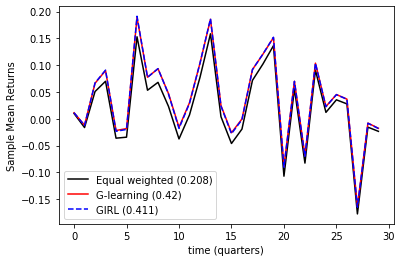

In [68]:
plt.plot(r_ew, label='Equal weighted (' + str(np.round(SR_ew,3)) + ')', color='black')
plt.plot(r_G, label='G-learning (' + str(np.round(SR_G,3)) + ')', color='red')
plt.plot(r_girl, label='GIRL (' + str(np.round(SR_GIRL,3)) + ')', color='blue', linestyle='--')

plt.legend()
plt.xlabel('time (quarters)')
plt.ylabel('Sample Mean Returns')

In [0]:
np.save('State_act_trajs.npy', trajs)

In [0]:
trajs = np.load('State_act_trajs.npy')

FileNotFoundError: ignored

In [0]:
print(len(trajs2[95][-1][0]))  # the number of asset position
print(len(trajs2[95]))  # the number of time steps in each trajectory

100
10


## G-IRL

In [0]:
def get_loss(trajs,
             num_steps, 
             benchmark_portf, 
             gamma, 
             num_risky_assets, 
             riskfree_rate, 
             expected_risky_returns, 
             Sigma_r, 
             x_vals_init, 
             max_iter_RL, 
             reward_params,
             beta, 
             num_trajs, 
             grad=False, 
             eps=1e-7):


  data_xvals = torch.zeros(num_trajs,  num_steps, num_assets, dtype=torch.float64, requires_grad=False)
  data_uvals = torch.zeros(num_trajs,  num_steps, num_assets, dtype=torch.float64, requires_grad=False)
        
  for n in range(num_trajs):
        for t in range(num_steps):
            data_xvals[n,t,:] = torch.tensor(trajs[n][t][0],dtype=torch.float64)
            data_uvals[n,t,:] = torch.tensor(trajs[n][t][1],dtype=torch.float64)
                
                
    # allocate memory for tensors that wil be used to compute the forward pass
  realized_rewards = torch.zeros(num_trajs, num_steps, dtype=torch.float64, requires_grad=False)
  realized_cum_rewards = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=False)

  realized_G_fun = torch.zeros(num_trajs, num_steps, dtype=torch.float64, requires_grad=False)
  realized_F_fun  = torch.zeros(num_trajs,  num_steps, dtype=torch.float64, requires_grad=False)

  realized_G_fun_cum = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=False)  
  realized_F_fun_cum = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=False)  

  reward_params_dict={}
  loss_dict={}
  loss_dict[-1]=np.array([0]*len(reward_params), dtype='float64') # perturb up
  loss_dict[1]=np.array([0]*len(reward_params), dtype='float64') # perturb down
  loss_grad = np.array([0]*len(reward_params), dtype='float64') 

  if grad: # compute gradient
    for j in range(len(reward_params)):
      for k in [-1,1]:
            reward_params_dict[k]=reward_params
            reward_params_dict[k][j]= reward_params_dict[k][j] + k*eps
              
            # 1. create a G-learner
            G_learner = G_learning_portfolio_opt(num_steps,
                                             reward_params_dict[k],
                                             beta,
                                             benchmark_portf,
                                             gamma,
                                             num_risky_assets,
                                             riskfree_rate,
                                             expected_risky_returns,
                                             Sigma_r,
                                             x_vals_init,
                                             use_for_WM=True)
        
            G_learner.reset_prior_policy()
        
            # run the G-learning recursion to get parameters of G- and F-functions
            G_learner.G_learning(error_tol, max_iter_RL)
        
            # compute the rewards and realized values of G- and F-functions from 
            # all trajectories
            for n in range(num_trajs):
              for t in range(num_steps):
                
                realized_rewards[n,t] = G_learner.compute_reward_on_traj(t,
                                data_xvals[n,t,:], data_uvals[n,t,:])


                realized_G_fun[n,t] = G_learner.compute_G_fun_on_traj(t,
                                data_xvals[n,t,:], data_uvals[n,t,:])


                realized_F_fun[n,t] = G_learner.compute_F_fun_on_traj(t,
                                data_xvals[n,t,:])
                
              realized_cum_rewards[n] = realized_rewards[n,:].sum()
              realized_G_fun_cum[n] = realized_G_fun[n,:].sum()
              realized_F_fun_cum[n] = realized_F_fun[n,:].sum()
          


            
            loss_dict[k][j] = - beta *(realized_G_fun_cum.sum() - realized_F_fun_cum.sum())
      loss_grad[j]=(loss_dict[1][j]-loss_dict[-1][j])/(2.0*eps)

  G_learner = G_learning_portfolio_opt(num_steps,
                                      reward_params,
                                      beta,
                                      benchmark_portf,
                                      gamma,
                                      num_risky_assets,
                                      riskfree_rate,
                                      expected_risky_returns,
                                      Sigma_r,
                                      x_vals_init,
                                      use_for_WM=True)
        
  G_learner.reset_prior_policy()
        
  G_learner.G_learning(error_tol, max_iter_RL)
        
  # compute the rewards and realized values of G- and F-functions from 
  # all trajectories
  for n in range(num_trajs):
      for t in range(num_steps):
                
                realized_rewards[n,t] = G_learner.compute_reward_on_traj(t,
                                data_xvals[n,t,:], data_uvals[n,t,:])


                realized_G_fun[n,t] = G_learner.compute_G_fun_on_traj(t,
                                data_xvals[n,t,:], data_uvals[n,t,:])


                realized_F_fun[n,t] = G_learner.compute_F_fun_on_traj(t,
                                data_xvals[n,t,:])
                
      realized_cum_rewards[n] = realized_rewards[n,:].sum()
      realized_G_fun_cum[n] = realized_G_fun[n,:].sum()
      realized_F_fun_cum[n] = realized_F_fun[n,:].sum()
          
        # 

  loss = - beta *(realized_G_fun_cum.sum() - realized_F_fun_cum.sum())   
  if grad:
    return loss, loss_grad
  else:
    return loss   


In [0]:
def GIRL(trajs,
         learning_rate,
         error_tol, 
         max_iter_RL,
         max_iter_IRL,
         num_steps, 
         lambd_init,
         omega_init,
         eta_init,
         rho_init,
         beta_init,
         benchmark_portf,
         gamma,
         num_risky_assets,
         riskfree_rate,
         expected_risky_returns,
         Sigma_r,
         x_vals_init):
    
    

    # Estimate parameters of the reward function using MaxEnt IRL
    #
    # Inputs:
    #     
    #  trajs - a list of trajectories. Each trajectory is a list of state-action pairs, 
    #         stored as a tuple. Each trajectory is assumed to be of the same length
    #
 

    use_for_WM = True
    num_assets = num_risky_assets + 1
    
    
    #with torch.autograd.set_detect_anomaly(True):
        
    lambd = torch.tensor(lambd_init, requires_grad=False, dtype=torch.float64)
    omega = torch.tensor(omega_init, requires_grad=False, dtype=torch.float64)
    beta = torch.tensor(beta_init, requires_grad=False, dtype=torch.float64)
    beta_prime = torch.tensor(beta_init, requires_grad=False, dtype=torch.float64)
    eta = torch.tensor(eta_init, requires_grad=False, dtype=torch.float64)
    rho = torch.tensor(rho_init, requires_grad=False, dtype=torch.float64)
   
    num_trajs = len(trajs)
    losses=[]
    scaling= True
    sc= []
    eps=1e-7
    lr=learning_rate 
    err=error_tol
    i =0 
    while (err>= error_tol) and (i < max_iter_IRL):
        print('GIRL iteration = ', i)
        print('lambd = ', lambd.detach().numpy())
        print('beta = ', beta.detach().numpy())
        
        # change of variables to enforce parameter constraints
        lambd_prime= torch.sqrt(lambd)
        omega_prime = torch.sqrt(omega)
        eta_prime= torch.sqrt(eta-1)
        rho_prime = torch.log(rho/(1-rho))

        reward_params = [lambd, omega, eta, rho]    
        rewards_prev=[lambd.clone().detach().numpy(), omega.clone().detach().numpy(), eta.clone().detach().numpy(), rho.clone().detach().numpy()]
  
        loss, loss_grad=get_loss(trajs,
                                 num_steps, 
                                 benchmark_portf, 
                                 gamma, 
                                 num_risky_assets, 
                                 riskfree_rate, 
                                 expected_risky_returns, 
                                 Sigma_r, 
                                 x_vals_init, 
                                 max_iter_RL, 
                                 reward_params, 
                                 beta,
                                 num_trajs, 
                                 grad=True, 
                                 eps=eps) 
        if scaling:
          
          sc=(1.0/np.abs(loss_grad))*np.abs(reward_params)
          sc[0]/=2.0*np.abs(lambd_prime)
          sc[1]/=2.0*np.abs(omega_prime)
          sc[2]/=2.0*np.abs(eta_prime)
          sc[3]/=torch.pow(torch.sigmoid(rho_prime),2)*torch.exp(-rho_prime)
          print("re-scaling:")
          print(sc)
          scaling = False
          
        #[lambd, omega, beta, eta, rho]
        #lambd -= lr*0.0001 * loss_grad[0]
        #omega -= 1000*lr * loss_grad[1]
        #beta -= 1000*lr * loss_grad[2]
        #eta -= lr * loss_grad[3]
        #rho -= lr*0.1* loss_grad[4]
        
        #Apply constraints (and do not optimize beta)
        lambd_prime -= lr* sc[0]* loss_grad[0]*2.0*lambd_prime  # must be positive
        omega_prime -= lr *sc[1]* loss_grad[1]*2.0*omega_prime # must be positive
        eta_prime -= lr * sc[2]*loss_grad[2]*2.0*eta_prime  # must be greater than 1
        rho_prime -= lr* sc[3]* loss_grad[3]*torch.pow(torch.sigmoid(rho_prime),2)*torch.exp(-rho_prime) # d sigmoid(x)/dx=sigmoid^2(x)e^{-x}

        lambd= torch.pow(lambd_prime,2)
        omega= torch.pow(omega_prime,2)
        eta = 1.0 + torch.pow(eta_prime,2)
        rho= torch.sigmoid(rho_prime)


        rewards_new=[lambd.detach().numpy(), omega.detach().numpy(), eta.detach().numpy(), rho.detach().numpy()]

        err=np.linalg.norm(np.array(rewards_prev)- np.array(rewards_new),2)

        print('Finished one step')
        print('loss = ', loss.detach().numpy())
        print('lambd = ', lambd.detach().numpy())
        print('omega = ',omega.detach().numpy())
        print('beta = ', beta.detach().numpy())
        print('eta = ', eta.detach().numpy())
        print('rho = ', rho.detach().numpy())
        print('error = ', err)
        losses.append(loss)
        i+=1
        
    lambd_np = lambd.detach().numpy()
    omega_np = omega.detach().numpy()
    beta_np = beta.detach().numpy()
    eta_np = eta.detach().numpy()
    rho_np = rho.detach().numpy()
        
    return lambd_np, omega_np, beta_np, eta_np, rho_np


### GIRL (G-learning IRL)

In [37]:
# The second version: compute using function GIRL defined outside of the class
# model parameters

lambd_0 = 0.01
omega_0 = 1.0 
eta_0 = 2.0 # 1.3 # 1.5 # 1.2
beta_0 = beta # 1.0 # 50.0 # 100.0
rho_0 = 0.5

# correct answer
#lambd = 0.001 # 0.001
#omega = 10*fee_stock 
#beta = 1000
#eta = 1.01 # 1.0#  1.3 # 1.5 # 1.2
#rho = 0.4

error_tol=1.e-4 # 5.0e-5 
max_iter_RL = 200
learning_rate = 0.5

max_iter_IRL = 200

t_0 = time.time()
#with torch.autograd.set_detect_anomaly(True):
with torch.no_grad():
    lambd, omega, beta, eta, rho = GIRL(trajs,
                                    learning_rate,
                                    error_tol,
                                    max_iter_RL,
                                    max_iter_IRL,
                                    num_steps,
                                    lambd_0,
                                    omega_0,
                                    eta_0,
                                    rho_0,
                                    beta_0,
                                    benchmark_portf,
                                    gamma,
                                    num_risky_assets,
                                    riskfree_rate,
                                    expected_risky_returns,
                                    Sigma_r,
                                    x_vals_init)

print('Great success!')

GIRL iteration =  0
lambd =  0.01
beta =  1000.0
Doing G-learning, it may take a few seconds...
Doing G-learning, it may take a few seconds...
Doing G-learning, it may take a few seconds...
Doing G-learning, it may take a few seconds...
Doing G-learning, it may take a few seconds...
Doing G-learning, it may take a few seconds...
Doing G-learning, it may take a few seconds...
Doing G-learning, it may take a few seconds...
Doing G-learning, it may take a few seconds...
re-scaling:
[1.44153229e-19 1.54482483e-16 1.94453699e-16 9.71729218e-17]
Finished one step
loss =  -261104486692698.7
lambd =  0.011025000000000002
omega =  0.25
beta =  1000.0
eta =  5.0
rho =  0.5621765008857981
error =  3.0929544076638766
GIRL iteration =  1
lambd =  0.011025000000000002
beta =  1000.0
Doing G-learning, it may take a few seconds...
Doing G-learning, it may take a few seconds...
Doing G-learning, it may take a few seconds...
Doing G-learning, it may take a few seconds...


KeyboardInterrupt: ignored

## Diagnostics of loss surface (optional)

In [0]:
#DGP
lambd = 0.001 
omega = 1.0 
beta = 1000.0
eta = 1.5 # 1.3 # 1.5 # 1.2
rho = 0.4

In [0]:
# GIRL
#lambd =  0.009123697248238735
#omega =  16.811312207749562
#beta =  0.00012804675779720459
#eta =  1.2258332366649625
#rho =  0.4372041372375515

lambd =  0.004870511120647702
omega =  30.30094109232191
beta =  200.0
eta =  1.2566887920624812
rho =  0.537995823823481

In [0]:
reward_params=[lambd, omega, eta, rho]

In [0]:
get_loss(trajs,
             num_steps, 
             benchmark_portf, 
             gamma, 
             num_risky_assets, 
             riskfree_rate, 
             expected_risky_returns, 
             Sigma_r, 
             x_vals_init, 
             max_iter_RL, 
             reward_params, 
             beta,
             len(trajs), 
             grad=False, 
             eps=1e-7)

Doing G-learning, it may take a few seconds...


tensor(30906466.5103, dtype=torch.float64, grad_fn=<MulBackward0>)

In [0]:
grid=np.arange(-0.9,0.9,0.1)
losses=[]
for omega_ in grid:
  reward_params=[lambd, omega+omega_, eta, rho]
  loss=get_loss(trajs,
             num_steps, 
             benchmark_portf, 
             gamma, 
             num_risky_assets, 
             riskfree_rate, 
             expected_risky_returns, 
             Sigma_r, 
             x_vals_init, 
             max_iter_RL, 
             reward_params, 
             beta,
             len(trajs), 
             grad=False, 
             eps=1e-7)
  print(omega+omega_, loss.detach().numpy())
  losses.append(loss.detach().numpy())


Text(0, 0.5, 'loss')

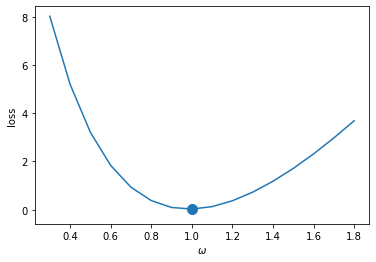

In [0]:
plt.plot(omega+grid[2:], np.array(losses[2:])/1e8)
plt.scatter(omega, losses[9]/1e8, s=100)
plt.xlabel('$\\omega$')
plt.ylabel('loss')

In [0]:
grid=np.arange(-0.3,0.4,0.1)
losses=[]
for rho_ in grid:
  reward_params=[lambd, omega, eta, rho+rho_]
  loss=get_loss(trajs,
             num_steps, 
             benchmark_portf, 
             gamma, 
             num_risky_assets, 
             riskfree_rate, 
             expected_risky_returns, 
             Sigma_r, 
             x_vals_init, 
             max_iter_RL, 
             reward_params,
             beta, 
             len(trajs), 
             grad=False, 
             eps=1e-7)
  print(rho+rho_, loss.detach().numpy())
  losses.append(loss.detach().numpy())

Doing G-learning, it may take a few seconds...
0.10000000000000003 929369007.2974191
Doing G-learning, it may take a few seconds...
0.20000000000000004 447955327.3361102
Doing G-learning, it may take a few seconds...
0.30000000000000004 124086829.57434654
Doing G-learning, it may take a few seconds...
0.4000000000000001 2852705.444678664
Doing G-learning, it may take a few seconds...
0.5 136954917.54810512
Doing G-learning, it may take a few seconds...
0.6000000000000001 562723160.1124332
Doing G-learning, it may take a few seconds...
0.7000000000000002 1254496646.422483


Text(0, 0.5, 'loss')

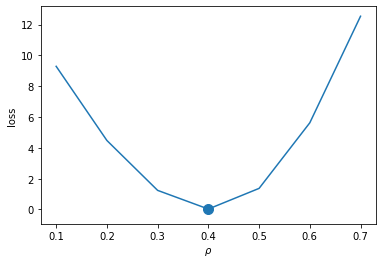

In [0]:
plt.plot(rho+grid, np.array(losses)/1e8)
plt.scatter(rho, losses[3]/1e8, s=100)
plt.xlabel('$\\rho$')
plt.ylabel('loss')

In [0]:
grid=np.arange(-1.0,1.0,0.2)
losses=[]
for eta_ in grid:
  reward_params=[lambd, omega, eta+eta_, rho]
  loss=get_loss(trajs,
             num_steps, 
             benchmark_portf, 
             gamma, 
             num_risky_assets, 
             riskfree_rate, 
             expected_risky_returns, 
             Sigma_r, 
             x_vals_init, 
             max_iter_RL, 
             reward_params, 
             beta,
             len(trajs), 
             grad=False, 
             eps=1e-7)
  print(eta+eta_, loss.detach().numpy()/1e8)
  losses.append(loss.detach().numpy())




Doing G-learning, it may take a few seconds...
0.5 3.042610239177886
Doing G-learning, it may take a few seconds...
0.7 1.5216423708429934
Doing G-learning, it may take a few seconds...
0.8999999999999999 0.647882915468365
Doing G-learning, it may take a few seconds...
1.0999999999999999 0.22558613525770604
Doing G-learning, it may take a few seconds...
1.2999999999999998 0.06820033564180136
Doing G-learning, it may take a few seconds...
1.4999999999999998 0.02871156067252159
Doing G-learning, it may take a few seconds...
1.6999999999999997 0.030523879465907813
Doing G-learning, it may take a few seconds...
1.8999999999999997 0.14363753302410245
Doing G-learning, it may take a few seconds...
2.0999999999999996 0.6162395933374762
Doing G-learning, it may take a few seconds...
2.3 1.9352640569864215


Text(0, 0.5, 'loss')

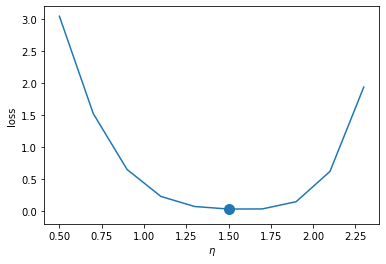

In [0]:
plt.plot(eta+grid, np.array(losses)/1e8)
plt.scatter(eta, losses[5]/1e8, s=100)
plt.xlabel('$\\eta$')
plt.ylabel('loss')

In [0]:
grid=np.arange(-0.0005,0.001,0.0001)
losses=[]
for lambd_ in grid:
  reward_params=[lambd+lambd_, omega, eta, rho]
  loss=get_loss(trajs,
             num_steps, 
             benchmark_portf, 
             gamma, 
             num_risky_assets, 
             riskfree_rate, 
             expected_risky_returns, 
             Sigma_r, 
             x_vals_init, 
             max_iter_RL, 
             reward_params, 
             beta,
             len(trajs), 
             grad=False, 
             eps=1e-7)
  print(lambd+lambd_, loss.detach().numpy())
  losses.append(loss.detach().numpy())

Doing G-learning, it may take a few seconds...
0.0005 454087831.9876529
Doing G-learning, it may take a few seconds...
0.0006000000000000001 283553495.787777
Doing G-learning, it may take a few seconds...
0.0007 156998464.844957
Doing G-learning, it may take a few seconds...
0.0007999999999999999 70207826.59114897
Doing G-learning, it may take a few seconds...
0.0009 19884921.663872898
Doing G-learning, it may take a few seconds...
0.001 2871156.0672447085
Doing G-learning, it may take a few seconds...
0.0010999999999999998 16111334.118157625
Doing G-learning, it may take a few seconds...
0.0012 56872295.623883605
Doing G-learning, it may take a few seconds...
0.0013 123957609.18611288
Doing G-learning, it may take a few seconds...
0.0014 214959912.78552264
Doing G-learning, it may take a few seconds...
0.0015 327963217.4461037
Doing G-learning, it may take a few seconds...
0.0015999999999999999 460280691.3997978
Doing G-learning, it may take a few seconds...
0.0017 612890694.367379
Do

Text(0, 0.5, 'loss')

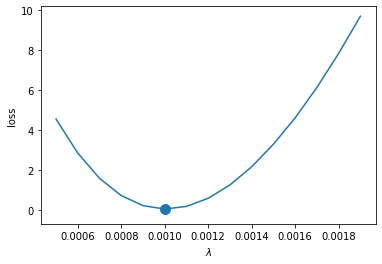

In [0]:
plt.plot(lambd+grid, np.array(losses)/1e8)
plt.scatter(lambd, losses[5]/1e8, s=100)
plt.xlabel('$\\lambda$')
plt.ylabel('loss')

## Plot rewards and cash injections

In [0]:
reward_params=[lambd, omega, eta, rho]
G_learner = G_learning_portfolio_opt(num_steps,
                                      reward_params,
                                      beta,
                                      benchmark_portf,
                                      gamma,
                                      num_risky_assets,
                                      riskfree_rate,
                                      expected_risky_returns,
                                      Sigma_r,
                                      x_vals_init,
                                      use_for_WM=True)

In [29]:
err_tol=1.e-10 # 5.0e-5 
max_iter=500

t_0 = time.time()
G_learner.reset_prior_policy()
G_learner.G_learning(err_tol=err_tol, max_iter=max_iter)
num_trajs = len(trajs)

data_xvals = torch.zeros(num_trajs,  num_steps, num_assets, dtype=torch.float64, requires_grad=False)
data_uvals = torch.zeros(num_trajs,  num_steps, num_assets, dtype=torch.float64, requires_grad=False)
num_trajs = len(trajs)       
for n in range(num_trajs):
        for t in range(num_steps):
            data_xvals[n,t,:] = torch.tensor(trajs[n][t][0],dtype=torch.float64)
            data_uvals[n,t,:] = torch.tensor(trajs[n][t][1],dtype=torch.float64)

realized_rewards = torch.zeros(num_trajs, num_steps, dtype=torch.float64, requires_grad=False)
realized_cum_rewards = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=False)

realized_G_fun = torch.zeros(num_trajs, num_steps, dtype=torch.float64, requires_grad=False)
realized_F_fun  = torch.zeros(num_trajs,  num_steps, dtype=torch.float64, requires_grad=False)

realized_G_fun_cum = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=False)  
realized_F_fun_cum = torch.zeros(num_trajs, dtype=torch.float64, requires_grad=False)         
# compute the rewards and realized values of G- and F-functions from 
# all trajectories
for n in range(num_trajs):
    for t in range(num_steps):
                
                realized_rewards[n,t] = G_learner.compute_reward_on_traj(t,
                                data_xvals[n,t,:], data_uvals[n,t,:])


                realized_G_fun[n,t] = G_learner.compute_G_fun_on_traj(t,
                                data_xvals[n,t,:], data_uvals[n,t,:])


                realized_F_fun[n,t] = G_learner.compute_F_fun_on_traj(t,
                                data_xvals[n,t,:])
                 
    realized_cum_rewards[n] = realized_rewards[n,:].sum()
    realized_G_fun_cum[n] = realized_G_fun[n,:].sum()
    realized_F_fun_cum[n] = realized_F_fun[n,:].sum()

print('Done in %f sec'% (time.time() - t_0))


Doing G-learning, it may take a few seconds...
Done in 35.003048 sec


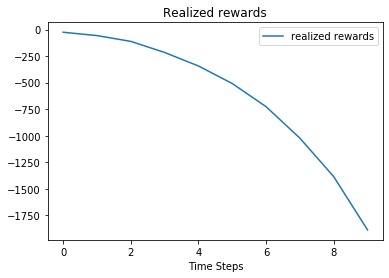

In [0]:
sim_idx =  999 # 4 # 8 # 6 # 5

realized_rewards = realized_rewards[sim_idx,:].detach().numpy()
plt.plot(realized_rewards,label='realized rewards')
# plt.plot(risky_asset_returns[:,asset_idx],label='realized_return',color='r')
plt.legend()
plt.xlabel('Time Steps')
plt.title('Realized rewards')
plt.show()



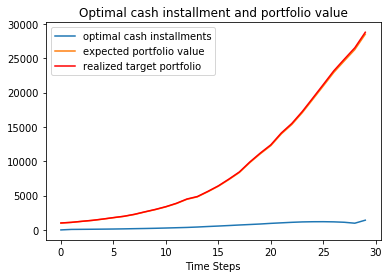

In [30]:
G_learner.project_cash_injections()

eta_ = G_learner.eta.detach().numpy()
realized_target_portf = eta_ * G_learner.expected_portf_val.numpy()

plt.plot(G_learner.expected_c_t, label='optimal cash installments')
plt.plot(G_learner.expected_portf_val, label='expected portfolio value')
plt.plot(realized_target_portf,label='realized target portfolio',color='r')

plt.legend()
# plt.ylim(-1000,2000)
plt.xlabel('Time Steps')
plt.title('Optimal cash installment and portfolio value')
# plt.savefig('G_learning_wealth_unconstrained.png')
plt.show()

In [36]:
for i in range(30):
 print(str(i+1) + "&" + str(np.round(G_learner.expected_c_t.detach().numpy()[i],3)) + "\\\\")

1&0.0\\
2&73.384\\
3&85.7\\
4&97.36\\
5&113.083\\
6&129.889\\
7&153.362\\
8&181.832\\
9&207.472\\
10&237.292\\
11&275.926\\
12&318.154\\
13&360.212\\
14&420.546\\
15&495.813\\
16&563.691\\
17&638.042\\
18&716.391\\
19&787.57\\
20&861.794\\
21&954.392\\
22&1030.161\\
23&1106.024\\
24&1164.276\\
25&1190.959\\
26&1196.982\\
27&1173.541\\
28&1112.945\\
29&976.385\\
30&1416.265\\


(array([  5.,   4.,  12.,  25.,  36.,  52.,  86., 100., 129., 112., 123.,
        101.,  86.,  56.,  34.,  22.,  10.,   3.,   3.,   1.]),
 array([-315267.86864726, -314109.08054033, -312950.2924334 ,
        -311791.50432647, -310632.71621953, -309473.9281126 ,
        -308315.14000567, -307156.35189874, -305997.56379181,
        -304838.77568488, -303679.98757795, -302521.19947102,
        -301362.41136409, -300203.62325716, -299044.83515023,
        -297886.04704329, -296727.25893636, -295568.47082943,
        -294409.6827225 , -293250.89461557, -292092.10650864]),
 <a list of 20 Patch objects>)

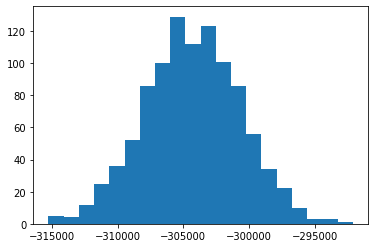

In [31]:
plt.hist(realized_cum_rewards.detach().numpy(), bins=20)